# Modelling continuous data with Tensoflow Probability

**Goal:** In this notebook you will learn how work with TFP. You will set up linear regression models that are able to output a gaussian conditional probability distribution. You will define different models with Keras and the Tensorflow probability framework and optimize the negative log likelihood (NLL). You will model the conditional probability distribution as a Normal distribution with a constant, montonic and flexible standart deviation $\sigma$. The mean $\mu$ of the CPD will always depend linearly on the input. You compare the performace of the 3 models based on the NLL on a validaiton set and use the one with the lowest NLL to predict the test set. Finally, you will also do an extrapolation experiment with the best model and look how the predicted CPD behaves.

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it. In addition you will find three exercises where you can do some experiments by yourself.

**Dataset:** 
You work with a simulated dataset that looks a bit like a fish when visualized in a scatterplot. The data is simulated to have  a linear slope but non-constant variance. The variance starts with a large value then slowly decreases to increase again and in the end it decreases again. You split the data into train, validation and test dataset.

**Content:**
* Work with a Normal distribution in TFP
* Simulate and split the dataset 
* Fit a model with keras and TFP that models the CPD with a linear mean $\mu$ and a fixed standart deviation $\sigma$
* Fit a model with keras and TFP that models the CPD with a linear mean $\mu$ and monotoic standart deviation $\sigma$
* Fit a model with keras and TFP that models the CPD with a linear mean $\mu$ and flexible standart deviation $\sigma$ (by adding hidden layers)
* Compare the different models based on the NLL loss on the validation dataset
* Choose one of these model to predict the test dataset and calculate the NLL on the test data
* Make a extrapolation experiment with the best model and look how the predicted CPD behaves

| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_05/nb_ch05_01.ipynb)



#### Install correct TF and TFP versions (colab only)

In [3]:
# Execute this cell to be sure to have a compatible TF (2.0) and TFP (0.8) version. 
# If you are bold you can skip this cell. 
try: #If running in colab 
  import google.colab
  !pip install tensorflow==2.0.0
  !pip install tensorflow_probability==0.8.0
except:
  print('Not running in colab')

In [1]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

#### Imports

In [23]:
import tensorflow as tf
# if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
#     print('Please install tensorflow 2.0 to run this notebook')
# print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp

%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.15.0
TF  Version 2.7.0


### Working with a TFP Normal distribution

Here you can see how to work with normal distribution in TFP.
#### Listing 5.1: Working with a TFP Normal distribution

In [24]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
import tensorflow_probability as tfp
tfd = tfp.distributions
d = tfd.Normal(loc=3, scale=1.5)           #A
x = d.sample(2) # Draw two random points.    #B
px = d.prob(x) # Compute density/mass.       #C
print(x)
print(px)
#A create a 1D Normal distribution with mean 3 and standard deviation 1.5
#B sample 2 realizations from the Normal distribution
#C compute the likelihood for each of the two sampled values under the defined Normal distribution 

tf.Tensor([3.4912028 1.7360613], shape=(2,), dtype=float32)
tf.Tensor([0.2520768  0.18648346], shape=(2,), dtype=float32)


#### Table 5.1:

Further methods for TensorFlow Distributions, see also table 5.1.

In [25]:
dist = tfd.Normal(loc=1.0, scale=0.1)
print('sample   :', dist.sample(3).numpy()) #Samples 3 numbers
print('prob     :',dist.prob((0,1,2)).numpy()) #Calculates the probabilities for positions 0,1,2
print('log_prob :',dist.log_prob((0,1,2)).numpy()) #Same as above just log
print('cdf      :',dist.cdf((0,1,2)).numpy()) #Calculates the cummulative distributions
print('mean     :',dist.mean().numpy()) #Returns the mean of the distribution
print('stddev   :',dist.stddev().numpy())

sample   : [1.0084225 0.9139096 1.0378124]
prob     : [7.6946093e-22 3.9894230e+00 7.6946093e-22]
log_prob : [-48.616352    1.3836466 -48.616352 ]
cdf      : [7.619853e-24 5.000000e-01 1.000000e+00]
mean     : 1.0
stddev   : 0.1


### Return to the book 
<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/Page_turn_icon_A.png" width="120" align="left" />  

### Simulate the fishlike data

In the next few cells you will simulate some (x,y)-data where the y increases on average linerly with x but has non-constant variance that so that scatterplot looks like a fish.You will fist simulate random distributed noise with non constant variance, then uniformly distributed x values between -1 and 6 and finally calculate corresponding y values with y = 2.7*x+noise (linear slope of 2.7 and intercept of 0). The variance of the noise will change, it starts with a high value of 12 and gets smaller until it is reaches a constant value of 1, then it grows again until a value of 15 to stay constant for a while and to decrease to 1 again. Look at the plot to understand the behavior of the variance. 

In [26]:
### define variance structure of the simulation
x1=np.arange(1,12,0.1)
x1=x1[::-1]
x2=np.repeat(1,30)
x3=np.arange(1,15,0.1)
x4=np.repeat(15,50)
x5=x3[::-1]
x6=np.repeat(1,20)
x=np.concatenate([x1,x2,x3,x4,x5,x6])
plt.plot(x)
plt.xlabel("index",size=16)
plt.ylabel("sigma",size=16)#pred
plt.show()


Now you will sample uniformly distributed x values in the range from -1 to 6. You will sample less x values in the range from -1 to 1. Finally you sort the x values (for ploting reasons). 

In [27]:
# generation the x values for the simulated data
np.random.seed(4710)
noise=np.random.normal(0,x,len(x))
np.random.seed(99)
first_part=len(x1)
x11=np.random.uniform(-1,1,first_part)
np.random.seed(97)
x12=np.random.uniform(1,6,len(noise)-first_part)
x=np.concatenate([x11,x12])
x=np.sort(x)

Let's put it all together to make the simulated fishlike data complete. You calculate y from the x values and the noise with a linear function where the slope is 2.7 and the intercept is 0, y=2.7*x+noise.  

In [28]:
## generation the y values for the simulated noise and the x values
y=2.7*x+noise

In [29]:
y=y.reshape((len(y),1))
x=x.reshape((len(x),1))

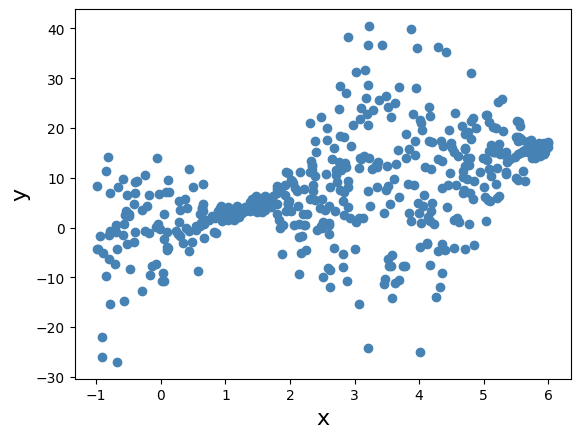

In [30]:
# lets visualize the data
plt.scatter(x,y,color="steelblue") 
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)#pred
plt.show()

#### Split data in train and test

In the next cells you will spilt the data x and y into a training, validation and test set. To get a first train and test dataset you just randomly sample 25% of the x and y values in the test dataset and the rest is the training dataset. The resulting training dataset gets splitted again into a training and validation dataset (80% training and 20% validation). After the splitting of the dataset you need to make sure that all the x values  from every dataset are in increasing order for ploting reasons (note that you also need to reorder the corresponding y values for all datasets).

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=47)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=22)

print("nr of traning samples = ",len(x_train))
print("nr of validation samples = ",len(x_val))
print("nr of test samples = ",len(x_test))


nr of traning samples =  293
nr of validation samples =  74
nr of test samples =  123


In [32]:
## reordering so x values are in increasiong order
order_idx_train=np.squeeze(x_train.argsort(axis=0))
x_train=x_train[order_idx_train]
y_train=y_train[order_idx_train]

order_idx_val=np.squeeze(x_val.argsort(axis=0))
x_val=x_val[order_idx_val]
y_val=y_val[order_idx_val]

order_idx_test=np.squeeze(x_test.argsort(axis=0))
x_test=x_test[order_idx_test]
y_test=y_test[order_idx_test]


Let's plot the training and validation data. You can see that it really looks a bit like a fish. In the following cells you will train different models on the training data, validate the loss (NLL) on the validation data and in the end you will predict the testdata with the best model. It's important to keep the testdata in a locked safe, because in practice it is unknown, until you decide which model you want to use to make a prediction. That is the reason why you will plot it only in the end.


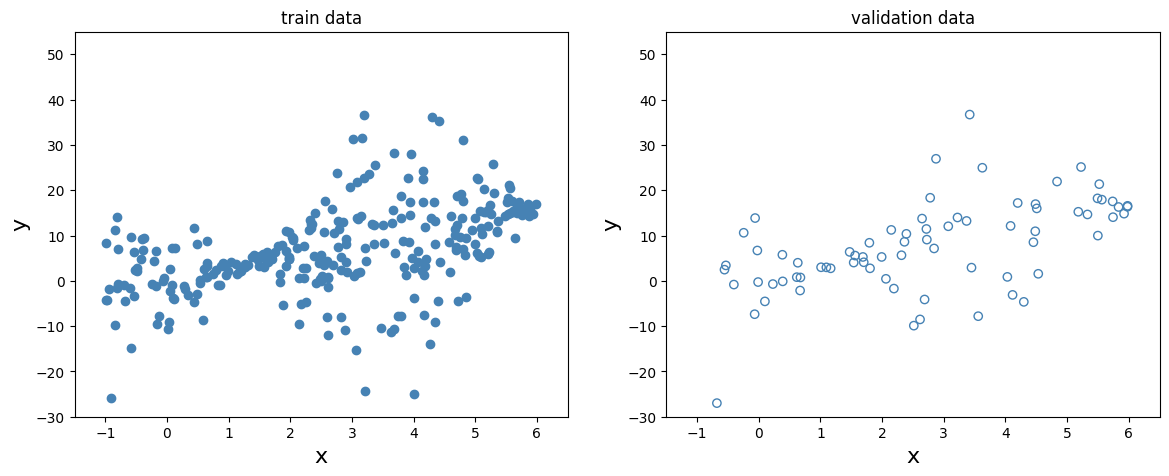

In [33]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])


plt.subplot(1,2,2)
plt.scatter(x_val,y_val,facecolors='none', edgecolors="steelblue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.savefig("5.fish.split.pdf")

## Fit a linear regression model with constant variance

In the next cells you will define and fit a linear model on the simulated fish data with keras and the tensorflow probability framework. You define a simple linear regression NN with only two parameters to model the output as a gaussian conditional probability distribution with constant $\sigma$ = 1 (scale). You use the NLL as loss function. In the TFP framework it is very easy to define the NLL as loss function (see A).



In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


def NLL(y, distr): 
  return -distr.log_prob(y) 

def my_dist(params):
  return tfd.Normal(loc=params, scale=1)

inputs = Input(shape=(1,))
params = Dense(1)(inputs)

dist = tfp.layers.DistributionLambda(my_dist)(params) 
model_sd_1 = Model(inputs=inputs, outputs=dist) 
model_sd_1.compile(Adam(), loss=NLL) 

model_sd_1.summary()

In [35]:
history = model_sd_1.fit(x_train, y_train, epochs=400, verbose=0, validation_data=(x_val,y_val))

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

In the next cell you define a model that predicts only the mean of the output distribution.

You see a nice decrease of the training and validation loss and after some time the loss converges. Let's evaluate the model by computeing the final train and validation loss.

In [ ]:
print(model_sd_1.evaluate(x_train,y_train, verbose=0))
print(model_sd_1.evaluate(x_val,y_val, verbose=0))

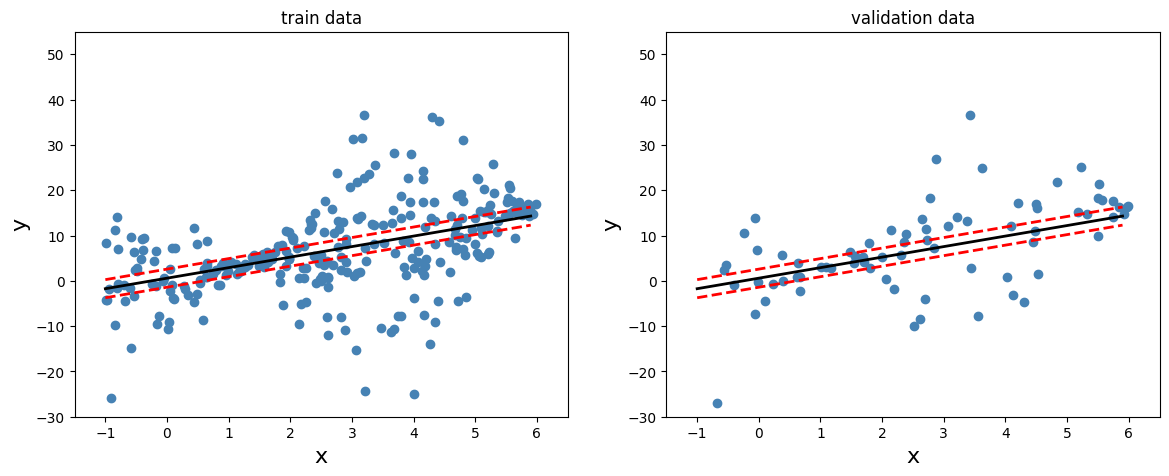

In [29]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_mean_sd_1.predict(x_pred)
sigma = 1
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()

You can use the same network as before just change the scale parameter in the Normal distribution .

In [ ]:
def NLL(y, distr): 
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params, scale=5)# set the sd to the fixed value 5

inputs = Input(shape=(1,))
params = Dense(1)(inputs)

dist = tfp.layers.DistributionLambda(my_dist)(params) 
model_sd_5 = Model(inputs=inputs, outputs=dist)
model_sd_5.compile(Adam(), loss=NLL) 

model_sd_5.summary()

In [39]:
history = model_sd_5.fit(x_train, y_train, epochs=400, verbose=0, validation_data=(x_val,y_val))

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()

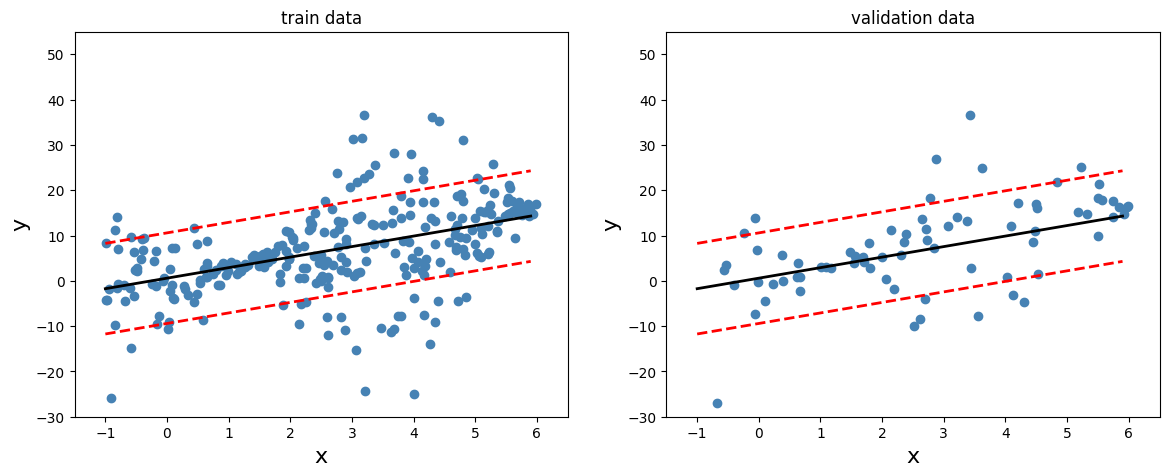

In [35]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_mean_sd_5.predict(x_pred)
sigma = 5
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()


#### NLL Results

In [ ]:
print(model_sd_5.evaluate(x_train,y_train, verbose=0))
print(model_sd_5.evaluate(x_val,y_val, verbose=0))

## Fit a linear regression model with non-constant variation.

In [43]:
def NLL(y, distr):
  return -distr.log_prob(y)

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))

inputs = Input(shape=(1,))
params = Dense(2)(inputs) 
dist = tfp.layers.DistributionLambda(my_dist)(params) 

model_monotoic_sd = Model(inputs=inputs, outputs=dist)
model_monotoic_sd.compile(Adam(learning_rate=0.01), loss=NLL) 


In [ ]:
model_monotoic_sd.summary()

In [45]:
history = model_monotoic_sd.fit(x_train, y_train, epochs=6000, verbose=0, validation_data=(x_val,y_val))

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.show()


#### NLL Result:  monotonic sigma

In [ ]:
print(model_monotoic_sd.evaluate(x_train,y_train, verbose=0))
print(model_monotoic_sd.evaluate(x_val,y_val, verbose=0))


- NLL still 3.5 and even a bit higher than the model with the estimated constant sigma, which had a NLL of ~3.5.
- The main reason for this is because the simulated variance is not monotonic.

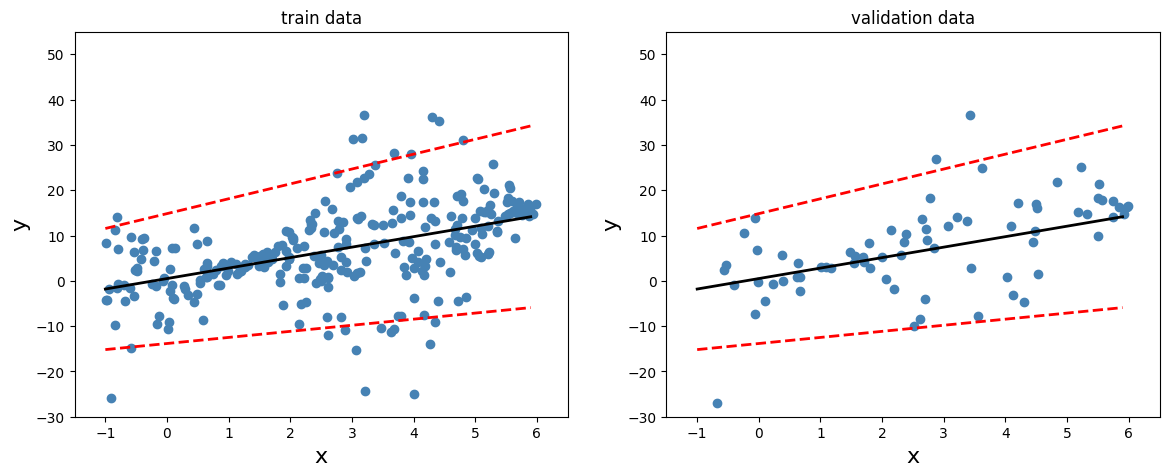

In [49]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_monotoic_sd_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()

## Fit a linear regression and allow the sd to depend in a flexible manner on the input

- We need a model where the standart deviation sigma is non-linear and able to increase for some x-values but then agian decrease for others. 
- We will now, define and fit a model that models the mean of the normal distribution linearly (no hidden layer for the mean parameter) 
- But for the standart devation sigma, we will use 2 hidden layers in beetween (with 30 and 20 nodes).


In [50]:
def NLL(y, distr):
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))

inputs = Input(shape=(1,))
out1 = Dense(1)(inputs) #
hidden1 = Dense(30,activation="relu")(inputs)
hidden1 = Dense(20,activation="relu")(hidden1)
hidden2 = Dense(20,activation="relu")(hidden1)
out2 = Dense(1)(hidden2) 
params = Concatenate()([out1,out2]) 
dist = tfp.layers.DistributionLambda(my_dist)(params) 

model_flex_sd = Model(inputs=inputs, outputs=dist)
model_flex_sd.compile(Adam(learning_rate=0.01), loss=NLL)


In [ ]:
model_flex_sd.summary()

In [52]:
history = model_flex_sd.fit(x_train, y_train, epochs=2000, verbose=0, validation_data=(x_val,y_val))

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.ylim(0,10)
plt.show()

#### NLL Result: flexible sigma 

In [ ]:
print(model_flex_sd.evaluate(x_train,y_train, verbose=0))
print(model_flex_sd.evaluate(x_val,y_val, verbose=0))

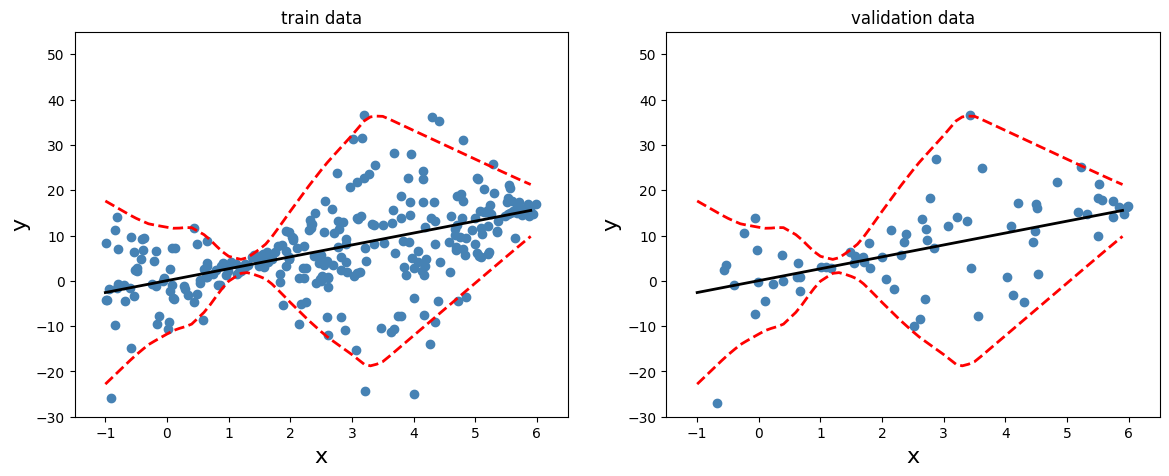

In [56]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_flex_sd_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()

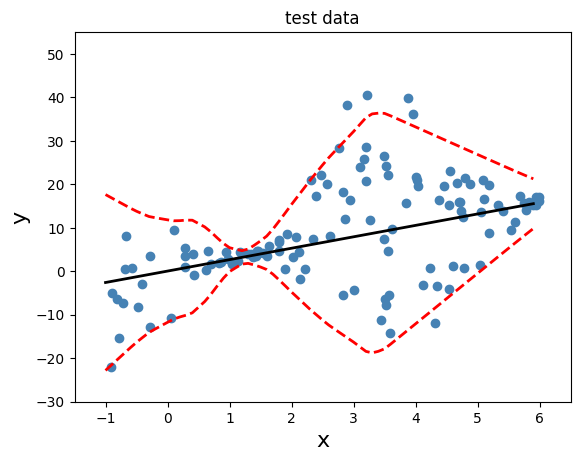

In [58]:
plt.scatter(x_test,y_test,color="steelblue") #observerd 
x_pred = np.arange(-1,6,0.1)
preds = model_flex_sd_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("test data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()